## What genre of music contains the most connected network?

### I will be looking at various centrality measures to determine the genre of music that contains the most social people. 

## Data:

### The data comes from: https://snap.stanford.edu/data/feather-deezer-social.html

### This network is collected from a social network of Deezer users in 2017. Deezer is a music streaming platform. The platform allows you to follow users. This network contains mutual follower relationships, so it doesn't contain a direction. Each node represents a user, with metadata attached, denoting the genres that they enjoy, based on the artists that are liked by the users. There are three different networks that are included. Data from: Romania, Croatia, and Hungary. The networks are quite large, which posed a challenge when conducting analysis.

## First We Will Import the necessary packages:

In [282]:
## Import Packages
import pandas as pd
import numpy as np
import networkx as nx
import nxviz as nv
import matplotlib.pyplot as plt
import json
import igraph as ig
import pyvis as pv
from IPython.core.display import display, HTML
import seaborn as sns


C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\290526204.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Next we will read in the data.
## The data consists of:

### * An excel file that has information on the edges in the network

### * A json file that has metadata information on the nodes in the dataset. The data contains genres that the nodes (users) liked


In [283]:
## Read in our dataframes with our edge information
df_ro = pd.read_csv("RO_edges.csv")
df_hr = pd.read_csv("HR_edges.csv")
df_hu = pd.read_csv("HU_edges.csv")



## Read in the json files from paths and then load them using the json.loads() function

json_list = ["RO_genres.json", "HR_genres.json", "HU_genres.json"]

with open(json_list[0], "r") as j:
    json1 = json.loads(j.read())
with open(json_list[1], "r") as j:
    json2 = json.loads(j.read())
with open(json_list[2], "r") as j:
    json3 = json.loads(j.read())

In [284]:
## Look at dataframe and datatypes
## Currently each edge relationship is denoted by two colummns with a node in each
print(df_ro.head())
print(df_ro.dtypes)

   node_1  node_2
0       0   37825
1       0   17224
2       0    6356
3       1   18053
4       1   31265
node_1    int64
node_2    int64
dtype: object


## Each node can have many different musical categories attached to it

In [285]:
## Look at the metadata that is contained within the json file
print(list(json1.items())[:2])

[('0', ['Films/Games', 'Dance', 'Pop', 'International Pop', 'Techno/House', 'R&B', 'Contemporary R&B', 'Film Scores', 'Electro']), ('1', ['Reggae', 'Electro', 'Dance', 'Rap/Hip Hop', 'Metal', 'Pop', 'East Coast', 'Techno/House', 'Rock', 'Alternative', 'Hard Rock'])]


## The JSONs with genre metadata need to be changed to dataframes:

In [286]:
## Convert the jsons to dataframes

genre_ro = pd.DataFrame(list(json1.items()), columns = ["node", "genre_list"])
genre_hr = pd.DataFrame(list(json2.items()), columns = ["node", "genre_list"]) 
genre_hu = pd.DataFrame(list(json3.items()), columns = ["node", "genre_list"]) 

## Look at the structure
genre_ro.describe()

,node,genre_list
count,41773,41773
unique,41773,15841
top,0,[Pop]
freq,1,4882


In [287]:
## look at data types:
genre_ro.dtypes

node          object
genre_list    object
dtype: object

In [288]:
genre_ro["node"] = genre_ro["node"].astype(int)
genre_hr["node"] = genre_hr["node"].astype(int)
genre_hu["node"] = genre_hu["node"].astype(int)

##  make sure the node is an int

genre_ro.dtypes

node           int32
genre_list    object
dtype: object

## The node metadata needs to be stored in a dictionary format before the networkx package will be able to interpret it properly:

In [289]:
## Data needs to be in a specific format to be easily read into a network. I will make

## Romanian Dataset
genre_ro["genre_list_dict"] = pd.DataFrame(genre_ro["genre_list"]).to_dict("records")
genre_ro["create_nodes"] = list(zip(genre_ro.node, genre_ro.genre_list_dict))

## Hungarian Dataset
genre_hu["genre_list_dict"] = pd.DataFrame(genre_hu["genre_list"]).to_dict("records")
genre_hu["create_nodes"] = list(zip(genre_hu.node, genre_hu.genre_list_dict))

## Croatian Dataset

genre_hr["genre_list_dict"] = pd.DataFrame(genre_hr["genre_list"]).to_dict("records")
genre_hr["create_nodes"] = list(zip(genre_hr.node, genre_hr.genre_list_dict))
genre_hr.head()

,node,genre_list,genre_list_dict,create_nodes
0,13357,[Pop],{'genre_list': ['Pop']},"(13357, {'genre_list': ['Pop']})"
1,11542,"[Indie Rock, Indie Pop/Folk, International Pop...","{'genre_list': ['Indie Rock', 'Indie Pop/Folk'...","(11542, {'genre_list': ['Indie Rock', 'Indie P..."
2,11543,"[Dance, Pop, Rock]","{'genre_list': ['Dance', 'Pop', 'Rock']}","(11543, {'genre_list': ['Dance', 'Pop', 'Rock']})"
3,11540,"[International Pop, Jazz, Pop]","{'genre_list': ['International Pop', 'Jazz', '...","(11540, {'genre_list': ['International Pop', '..."
4,11541,[Rap/Hip Hop],{'genre_list': ['Rap/Hip Hop']},"(11541, {'genre_list': ['Rap/Hip Hop']})"


In [290]:
## A column for the edge list will make working with the data more convenient
df_ro["edges"] = list(zip(df_ro.node_1, df_ro.node_2))
df_hr["edges"] = list(zip(df_hr.node_1, df_hr.node_2))
df_hu["edges"] = list(zip(df_hu.node_1, df_hu.node_2))

## The information on the dataset said that there were 84 total genres that the nodes could have. By looping over the dataframe of node metadata, we can check this

In [291]:
## Initiate an empty list to store genres
list_of_genres = []
for row in genre_ro["genre_list_dict"]:
    for music_list in row.values():
        for item in music_list:
            if item not in list_of_genres:
                list_of_genres.append(item)

## 84 values are expected
len(list_of_genres)

84

## Lets look at what some of the categories that are included in the networks:

In [292]:
list_of_genres

['Films/Games',
 'Dance',
 'Pop',
 'International Pop',
 'Techno/House',
 'R&B',
 'Contemporary R&B',
 'Film Scores',
 'Electro',
 'Reggae',
 'Rap/Hip Hop',
 'Metal',
 'East Coast',
 'Rock',
 'Alternative',
 'Hard Rock',
 'Disco',
 'Singer & Songwriter',
 'Trance',
 'Latin Music',
 'Indie Rock',
 'Dancefloor',
 'Indie Pop/Folk',
 'Indie Rock/Rock pop',
 'Dancehall/Ragga',
 'Indie Pop',
 'Country',
 'Rock & Roll/Rockabilly',
 'Blues',
 'Dubstep',
 'Electro Hip Hop',
 'Kids',
 'Chill Out/Trip-Hop/Lounge',
 'Electro Pop/Electro Rock',
 'Contemporary Soul',
 'Classical',
 'Vocal jazz',
 'Jazz',
 'Dub',
 'Soundtracks',
 'Comedy',
 'Alternative Country',
 'TV Soundtracks',
 'Musicals',
 'Folk',
 'Grime',
 'Asian Music',
 'Oldschool R&B',
 'Brazilian Music',
 'Spirituality & Religion',
 'Old school soul',
 'Game Scores',
 'Dirty South',
 'Soul & Funk',
 'Old School',
 'Modern',
 'West Coast',
 'Instrumental jazz',
 'Opera',
 'Urban Cowboy',
 'Sports',
 'Chicago Blues',
 'Bolero',
 'Baroque',


## Lets determine the frequency of genres in each of the datasets:

In [293]:
country_genre_counts = pd.DataFrame()
country_genre_counts["category"] = list_of_genres
df_list = [genre_ro, genre_hu, genre_hr]
df_str = ["romanian_counts",  "hungarian_counts", "croatian_counts"]
index = 0
for df in df_list:
    genre_counts = {}
    for row in df["genre_list_dict"]:
        for music_list in row.values():
            for item in music_list:
                if item not in genre_counts.keys():
                    genre_counts[item] = 1
                else:
                    genre_counts[item] += 1
    country_genre_counts[df_str[index]] = genre_counts.values()
    index += 1

## Now we can look at what genres are the most popular in the three different networks. I have created a filtered list of the genres as well, that only contains genres that have at least 1000 nodes. This is for when centrality measures are being measured, as genres with small amount of nodes might have large centrality measures that are not exactly honest due to the size of the sample.

In [294]:
## Create a list of genres which are filtered so that they must contain at least 1000 nodes. This will be useful for later centrality measures
romanian_genre_list = country_genre_counts["category"][country_genre_counts["romanian_counts"] > 1000]

country_genre_counts.sort_values(by  = ["romanian_counts"], ascending= False)[["category","romanian_counts"]].head(10)

,category,romanian_counts
2,Pop,33420
1,Dance,21208
10,Rap/Hip Hop,18849
13,Rock,16630
8,Electro,16550
14,Alternative,14966
5,R&B,11933
3,International Pop,11620
20,Indie Rock,7365
0,Films/Games,7353


##  Romania's most popular genres are Pop, Dance, Hip Hop, Rock and Electro

In [295]:

hungarian_genre_list = country_genre_counts["category"][country_genre_counts["hungarian_counts"] > 1000]
country_genre_counts.sort_values(by = ["hungarian_counts"], ascending= False)[["category", "hungarian_counts"]].head(10)

,category,hungarian_counts
7,Film Scores,37889
5,R&B,25201
0,Films/Games,22749
1,Dance,21033
2,Pop,18620
10,Rap/Hip Hop,17585
16,Disco,13830
17,Singer & Songwriter,11134
20,Indie Rock,10181
3,International Pop,9458


## Romania's most popular genres are film scores, R&B, Films/Games, Dance, and Pop 

In [296]:
country_genre_counts.sort_values(by = ["croatian_counts"], ascending= False)[["category", "croatian_counts"]].head(10)

,category,croatian_counts
0,Films/Games,47303
8,Electro,27101
5,R&B,25998
4,Techno/House,21142
7,Film Scores,20707
11,Metal,19654
15,Hard Rock,15164
3,International Pop,13723
1,Dance,12111
2,Pop,12030


## Croatia's most popular genres are Films/Games, Electro, R&B,  Techno, and Film Scores

In [297]:
## Create filtered list for further analysis later
croatian_genre_list = country_genre_counts["category"][country_genre_counts["croatian_counts"] > 1000]
filtered_genres_list = [romanian_genre_list, hungarian_genre_list, croatian_genre_list]

## Interestingly, the top genres for all three countries are quite different. It will be cool to see if this has an impact on the connectedness of the networks, or if the most connected genre will still be consistent accross all of the networks. Romania enjoys more conventional genres, while Croatia and Hungary prefer movie/game scores as well as electronic or dance music

## Now lets Create our Networks:

### * For each country, a networkx network will be initiated

In [298]:
## initiate all networks
graph_ro = nx.Graph()
graph_hu = nx.Graph()
graph_cr = nx.Graph()

## Create romanian Network
graph_ro.add_nodes_from(genre_ro["create_nodes"], key =int)
graph_ro.add_edges_from(df_ro["edges"])

## Create hungarian Network
graph_hu.add_nodes_from(genre_hu["create_nodes"], key =int)
graph_hu.add_edges_from(df_hu["edges"])


## Create croatian network
graph_cr.add_nodes_from(genre_hr["create_nodes"], key =int)
graph_cr.add_edges_from(df_hr["edges"])


## Lets look at the data contained within our network nodes. There should be:

### * A node
### * A metadata list of genres

In [299]:
list(graph_ro.nodes(data = True))[:2]

[(0,
  {'key': int,
   'genre_list': ['Films/Games',
    'Dance',
    'Pop',
    'International Pop',
    'Techno/House',
    'R&B',
    'Contemporary R&B',
    'Film Scores',
    'Electro']}),
 (1,
  {'key': int,
   'genre_list': ['Reggae',
    'Electro',
    'Dance',
    'Rap/Hip Hop',
    'Metal',
    'Pop',
    'East Coast',
    'Techno/House',
    'Rock',
    'Alternative',
    'Hard Rock']})]

## Check the number of nodes and edges:

In [300]:
## Romanian Counts
print("Romanian Nodes: " + str(graph_ro.number_of_nodes()))
print("Romanian Edges: " + str(graph_ro.number_of_edges()))

## Croatian Counts

print("Croatian Nodes: " + str(graph_cr.number_of_nodes()))
print("Croatian Edges: " + str(graph_cr.number_of_edges()))

## Hungarian Counts

print("Hungarian Nodes: " + str(graph_hu.number_of_nodes()))
print("Hungarian Edges: " + str(graph_hu.number_of_edges()))

Romanian Nodes: 41773
Romanian Edges: 125826
Croatian Nodes: 54573
Croatian Edges: 498202
Hungarian Nodes: 47538
Hungarian Edges: 222887


## All of the networks contain similar amounts of nodes, but Croatia contains many more edges. This implies that it will be far more connected than Romania and Hungaria

## The network is too large to reliably visualize, but we can take a sample of it and visualize that:

In [301]:
sample  = df_ro.sample(1000, random_state = 1)
sample.head(10)

,node_1,node_2,edges
3261,529,10633,"(529, 10633)"
55424,10369,27113,"(10369, 27113)"
89525,19103,34460,"(19103, 34460)"
10152,1672,26353,"(1672, 26353)"
38241,6803,8875,"(6803, 8875)"
80197,16305,26490,"(16305, 26490)"
21214,3634,14532,"(3634, 14532)"
19874,3384,36619,"(3384, 36619)"
12417,2063,34875,"(2063, 34875)"
54376,10154,34896,"(10154, 34896)"


In [302]:
net = pv.network.Network(height = "1000px", width = "100%", notebook = False )
pyviz_nodes = list(set([*sample.node_1, *sample.node_2]))
pyviz_edges = sample[["node_1","node_2"]].values.tolist()
net.add_nodes(pyviz_nodes)
net.add_edges(pyviz_edges)


In [327]:
net.show("practice_net.html", notebook = False)

practice_net.html


## Now the centrality measures should be examined:

In [304]:
## Romanian Centrality measures
degree_centrality_ro = nx.degree_centrality(graph_ro)
eigen_centrality_ro = nx.eigenvector_centrality(graph_ro)

## Croatian Centrality measures
degree_centrality_cr = nx.degree_centrality(graph_cr)
eigen_centrality_cr = nx.eigenvector_centrality(graph_cr)

## Hungarian Centrality measures
degree_centrality_hu = nx.degree_centrality(graph_hu)
eigen_centrality_hu = nx.eigenvector_centrality(graph_hu)

## In order to find betweenness centrality, we must convert the network to an igraph network. The algorithm that networkx uses is too slow for networks that are as large as the three that are being examined

igraph_ro = ig.Graph.from_networkx(graph_ro)
igraph_cr = ig.Graph.from_networkx(graph_cr)
igraph_hu = ig.Graph.from_networkx(graph_hu)


In [305]:
## Calculate beteenness centrality

betweenness_centrality_ro = igraph_ro.betweenness(directed = False)

In [306]:
betweenness_centrality_cr = igraph_cr.betweenness(directed = False)

In [307]:
betweenness_centrality_hu = igraph_hu.betweenness(directed =False)

## A centrality dataframe is created for each of the networks, and degree centrality, eigenvector centrality and betweenness centrality are calculated

In [308]:
## lets add centrality values to our genre dataframe

## Romanian Dataframe
genre_ro["degree_centrality"] = degree_centrality_ro.values()
genre_ro["eigenvector_centrality"] = eigen_centrality_ro.values()
genre_ro["betweenness_centrality"] = betweenness_centrality_ro
## Croation Dataframe
genre_hr["degree_centrality"] = degree_centrality_cr.values()
genre_hr["eigenvector_centrality"] = eigen_centrality_cr.values()
genre_hr["betweenness_centrality"] = betweenness_centrality_cr

## Hungarian Dataframe
genre_hu["degree_centrality"] = degree_centrality_hu.values()
genre_hu["eigenvector_centrality"] = eigen_centrality_hu.values()
genre_hu["betweenness_centrality"] = betweenness_centrality_hu

In [309]:
## Sort hungarian values by descending degree_centrality
genre_hu.sort_values(by = ["betweenness_centrality"], ascending= False)

,node,genre_list,genre_list_dict,create_nodes,degree_centrality,eigenvector_centrality,betweenness_centrality
14900,14900,"[Techno/House, Dance, Electro, Pop]","{'genre_list': ['Techno/House', 'Dance', 'Elec...","(14900, {'genre_list': ['Techno/House', 'Dance...",0.002356,3.175087e-02,8.877837e+06
40491,40491,"[Comedy, Dance, Rap/Hip Hop, Pop, R&B, Rock, E...","{'genre_list': ['Comedy', 'Dance', 'Rap/Hip Ho...","(40491, {'genre_list': ['Comedy', 'Dance', 'Ra...",0.002041,8.660385e-03,7.066625e+06
24218,24218,"[International Pop, Rap/Hip Hop, Latin Music, ...","{'genre_list': ['International Pop', 'Rap/Hip ...","(24218, {'genre_list': ['International Pop', '...",0.001851,7.635477e-03,5.833603e+06
14597,14597,"[Rap/Hip Hop, Pop]","{'genre_list': ['Rap/Hip Hop', 'Pop']}","(14597, {'genre_list': ['Rap/Hip Hop', 'Pop']})",0.001725,8.568430e-03,5.663767e+06
15724,15724,"[Films/Games, Dancefloor, International Pop, R...","{'genre_list': ['Films/Games', 'Dancefloor', '...","(15724, {'genre_list': ['Films/Games', 'Dancef...",0.001830,9.452062e-03,4.975937e+06
...,...,...,...,...,...,...,...
16573,16573,[Rap/Hip Hop],{'genre_list': ['Rap/Hip Hop']},"(16573, {'genre_list': ['Rap/Hip Hop']})",0.000021,7.779920e-07,0.000000e+00
41217,41217,"[Pop, Rock]","{'genre_list': ['Pop', 'Rock']}","(41217, {'genre_list': ['Pop', 'Rock']})",0.000021,9.109243e-07,0.000000e+00
6653,6653,"[International Pop, Rap/Hip Hop, Pop, R&B]","{'genre_list': ['International Pop', 'Rap/Hip ...","(6653, {'genre_list': ['International Pop', 'R...",0.000021,2.575258e-05,0.000000e+00
6666,6666,"[Films/Games, Indie Rock, R&B, International P...","{'genre_list': ['Films/Games', 'Indie Rock', '...","(6666, {'genre_list': ['Films/Games', 'Indie R...",0.000021,9.625089e-06,0.000000e+00


## Now the centrality of each category in each network can be reliably determined. The average degree centrality of the nodes in each genre is calculated using the for loop below:

In [310]:
centrality_hr = pd.DataFrame()
centrality_ro = pd.DataFrame()
centrality_hu = pd.DataFrame()

str_list = ["centrality_ro", "centrality_hu", "centrality_hr"]
counts_list = ["romanian_counts","hungarian_counts", "croatian_counts"]
centrality_dict = {}
index = 0
for df in df_list:
    temp_dict = {}
    for genre in filtered_genres_list[index]:
        temp_dict[genre] =  np.average(df[df["genre_list"].apply(lambda x: genre in x)]["degree_centrality"])
    
    centrality_dict[str_list[index]] = temp_dict
    index += 1

Now the average eigenvector centrality:

In [311]:
eigen_centrality_dict = {}
index = 0
for df in df_list:
    temp_dict = {}
    for genre in filtered_genres_list[index]:
        temp_dict[genre] =  np.average(df[df["genre_list"].apply(lambda x: genre in x)]["eigenvector_centrality"])
    
    eigen_centrality_dict[str_list[index]] = temp_dict
    
    index += 1

In [312]:
centrality_df = pd.DataFrame(data = centrality_dict["centrality_ro"], index = [0])
centrality_df = centrality_df.append(centrality_dict["centrality_hu"], ignore_index= True)
centrality_df = centrality_df.append(centrality_dict["centrality_hr"], ignore_index= True)
centrality_df["dataset"] = ["romanian", "hungarian", "croatian"]
centrality_df = pd.melt(centrality_df,id_vars= "dataset")


C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\2791416771.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centrality_df = centrality_df.append(centrality_dict["centrality_hu"], ignore_index= True)
C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\2791416771.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centrality_df = centrality_df.append(centrality_dict["centrality_hr"], ignore_index= True)


In [313]:
eigen_centrality_df = pd.DataFrame(data = eigen_centrality_dict["centrality_ro"], index = [0])
eigen_centrality_df = eigen_centrality_df.append(eigen_centrality_dict["centrality_hu"], ignore_index= True)
eigen_centrality_df = eigen_centrality_df.append(eigen_centrality_dict["centrality_hr"], ignore_index= True)
eigen_centrality_df["dataset"] = ["romanian", "hungarian", "croatian"]
eigen_centrality_df = pd.melt(eigen_centrality_df,id_vars= "dataset")

C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\1563779340.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eigen_centrality_df = eigen_centrality_df.append(eigen_centrality_dict["centrality_hu"], ignore_index= True)
C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\1563779340.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eigen_centrality_df = eigen_centrality_df.append(eigen_centrality_dict["centrality_hr"], ignore_index= True)


## We can order all centrality measures of genres in each network by highest value:

In [314]:
eigen_centrality_df[eigen_centrality_df["dataset"]== "romanian"].sort_values(by = ["value"], ascending= False).head(15)

,dataset,variable,value
81,romanian,Dubstep,0.001480
60,romanian,Dancefloor,0.001219
18,romanian,Contemporary R&B,0.001108
84,romanian,Kids,0.001085
9,romanian,International Pop,0.001041
21,romanian,Film Scores,0.000991
0,romanian,Films/Games,0.000962
51,romanian,Singer & Songwriter,0.000882
15,romanian,R&B,0.000858
42,romanian,Alternative,0.000854


## Romania's highest average centrality measures are dance type music, such as dubstep, dancefloor, r and b and pop

In [315]:
eigen_centrality_df[eigen_centrality_df["dataset"]== "hungarian"].sort_values(by = ["value"], ascending= False).head(15)

,dataset,variable,value
82,hungarian,Dubstep,0.000697
10,hungarian,International Pop,0.000684
61,hungarian,Dancefloor,0.000683
7,hungarian,Pop,0.000675
100,hungarian,Alternative Country,0.000631
16,hungarian,R&B,0.000625
52,hungarian,Singer & Songwriter,0.000621
19,hungarian,Contemporary R&B,0.000610
31,hungarian,Rap/Hip Hop,0.000609
22,hungarian,Film Scores,0.000601


## Hungaria's highest average centrality measures are also dance type music: dubstep, international pop, dancefloor, and pop

In [316]:
eigen_centrality_df[eigen_centrality_df["dataset"]== "croatian"].sort_values(by = ["value"], ascending= False).head(15)

,dataset,variable,value
83,croatian,Dubstep,0.003272
122,croatian,Electro Hip Hop,0.002580
32,croatian,Rap/Hip Hop,0.002294
11,croatian,International Pop,0.002245
14,croatian,Techno/House,0.002229
20,croatian,Contemporary R&B,0.002195
5,croatian,Dance,0.002107
23,croatian,Film Scores,0.002106
2,croatian,Films/Games,0.002096
26,croatian,Electro,0.002085


## Croatia's genres with the highest average centrality are dubstep, electro hip hop, rap/hip hop, international pop and techno/house

C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\243912616.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "croatian"][eigen_centrality_df["value"] > 0].sort_values(by = ["value"], ascending = False), x = "variable", y = "value").set_title("Average Centrality of Croatian Genres", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})


Text(0.5, 1.0, 'Average Centrality of Croatian Genres')

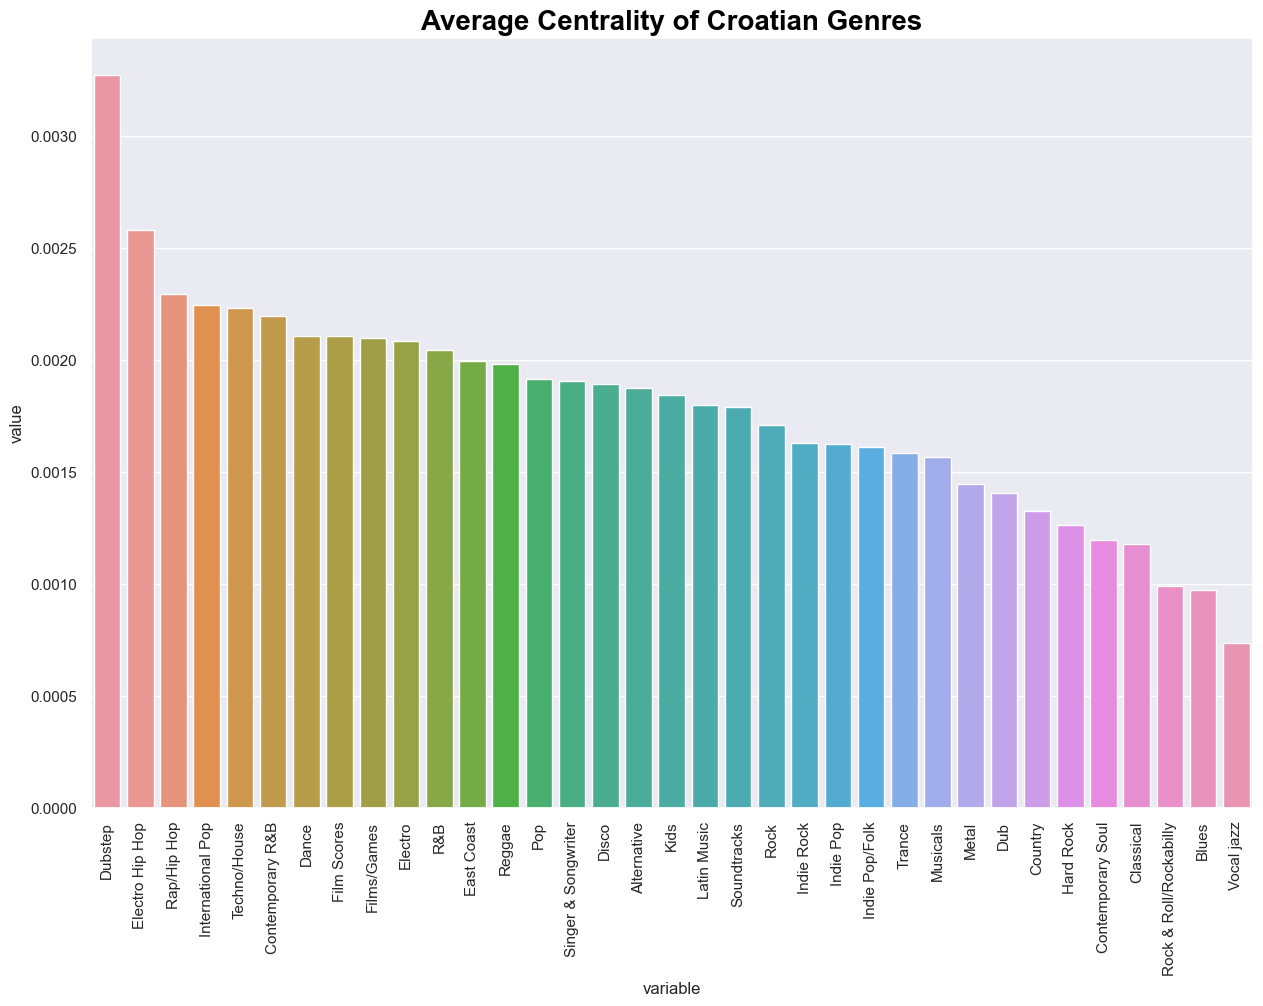

In [317]:
plt.xticks(rotation = 90)
sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "croatian"][eigen_centrality_df["value"] > 0].sort_values(by = ["value"], ascending = False), x = "variable", y = "value").set_title("Average Centrality of Croatian Genres", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})

C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\1859669917.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "romanian"][eigen_centrality_df["value"] > 0].sort_values(by = ["value"], ascending = False), x = "variable", y = "value").set_title("Average Centrality of Romanian Genres", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})


Text(0.5, 1.0, 'Average Centrality of Romanian Genres')

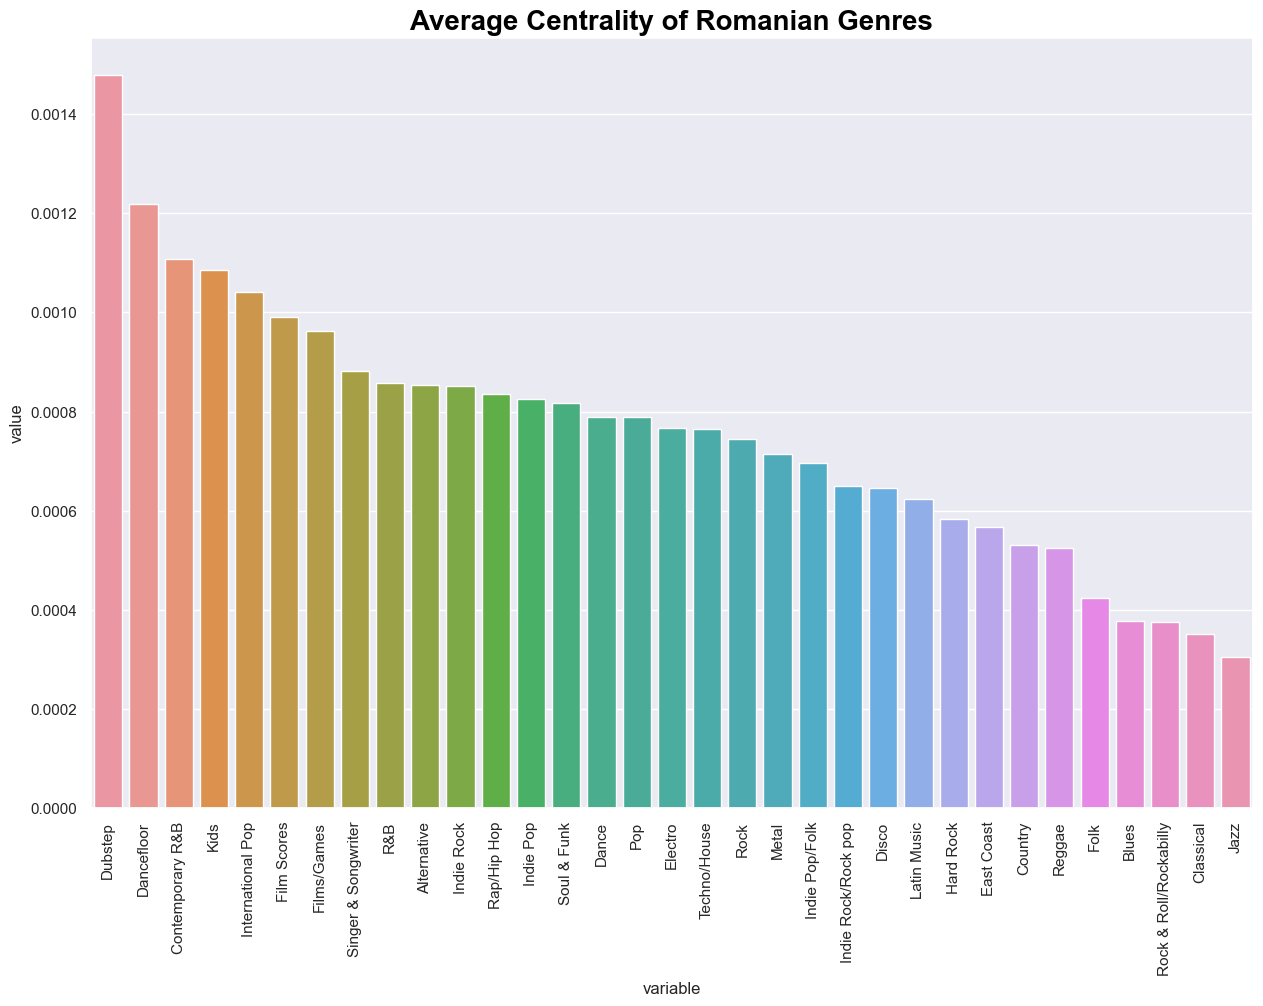

In [318]:
plt.xticks(rotation = 90)
sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "romanian"][eigen_centrality_df["value"] > 0].sort_values(by = ["value"], ascending = False), x = "variable", y = "value").set_title("Average Centrality of Romanian Genres", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})

C:\Users\Steve\AppData\Local\Temp\ipykernel_5084\3631166350.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "hungarian"][eigen_centrality_df["value"] > 0.0004].sort_values(by = ["value"], ascending = False), x = "variable", y = "value").set_title("Average Centrality of Hungarian Genres", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})


Text(0.5, 1.0, 'Average Centrality of Hungarian Genres')

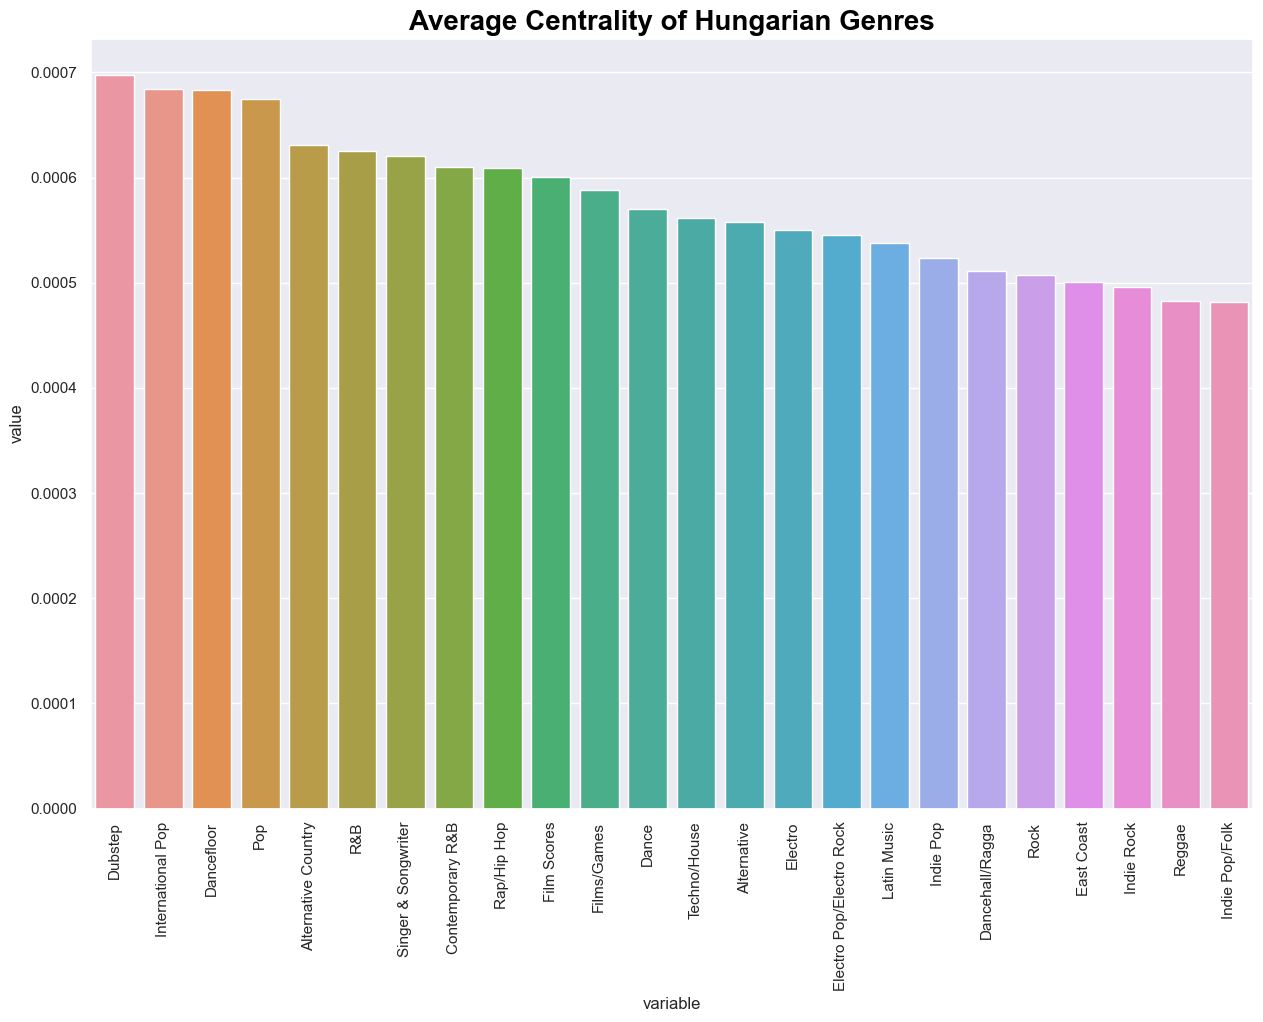

In [319]:
plt.xticks(rotation = 90)
sns.barplot(data = eigen_centrality_df[eigen_centrality_df["dataset"] == "hungarian"][eigen_centrality_df["value"] > 0.0004].sort_values(by = ["value"], ascending = False), x = "variable", y = "value").set_title("Average Centrality of Hungarian Genres", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})

## Based on this information, we can conclude that people that enjoy genres that are dance related (dubstep, pop, dancefloor) on average contain more connected, or more social people

## Now that we've looked at average centrality measures for the networks, we can look at group centrality measures to determine how social the they are as a unit:

In [320]:
group_centrality = [genre_ro, genre_hu, genre_hr]
index = 0
cluster_df = pd.DataFrame()
country_selection = ["romanian", "hungarian", "croatian"]
graph_selection = [graph_ro,graph_hu,graph_cr]
for df in df_list:
    temp_df = pd.DataFrame()
    temp_list = []
    for genre in list_of_genres:
        temp_list.append(nx.group_degree_centrality(graph_selection[index],list(df[df["genre_list"].apply(lambda x: genre in x)]["node"])))
    temp_df["category"] = list_of_genres
    temp_df["country"] = country_selection[index]
    temp_df["group_degree_centrality"] = temp_list
    cluster_df = pd.concat([cluster_df,temp_df])
    index += 1

In [321]:
cluster_df = cluster_df.sort_values(by = ["group_degree_centrality"],ascending  = False)
cluster_df.head(20)

,category,country,group_degree_centrality
2,Pop,croatian,0.991197
2,Pop,hungarian,0.984869
2,Pop,romanian,0.963726
13,Rock,croatian,0.944742
1,Dance,croatian,0.941504
1,Dance,hungarian,0.926803
13,Rock,hungarian,0.916921
14,Alternative,croatian,0.912420
8,Electro,croatian,0.908588
10,Rap/Hip Hop,croatian,0.901858


## Across the board, Pop music has the highest group centrality of any genre. Even though pop wasn't the most popular genre in the networks, all pop music has above a 0.95 centrality measure. This means that the group of pop nodes that are in the network have connections to almost every other node outside of the pop genre.

Text(0.5, 1.0, 'The group centrality of all networks')

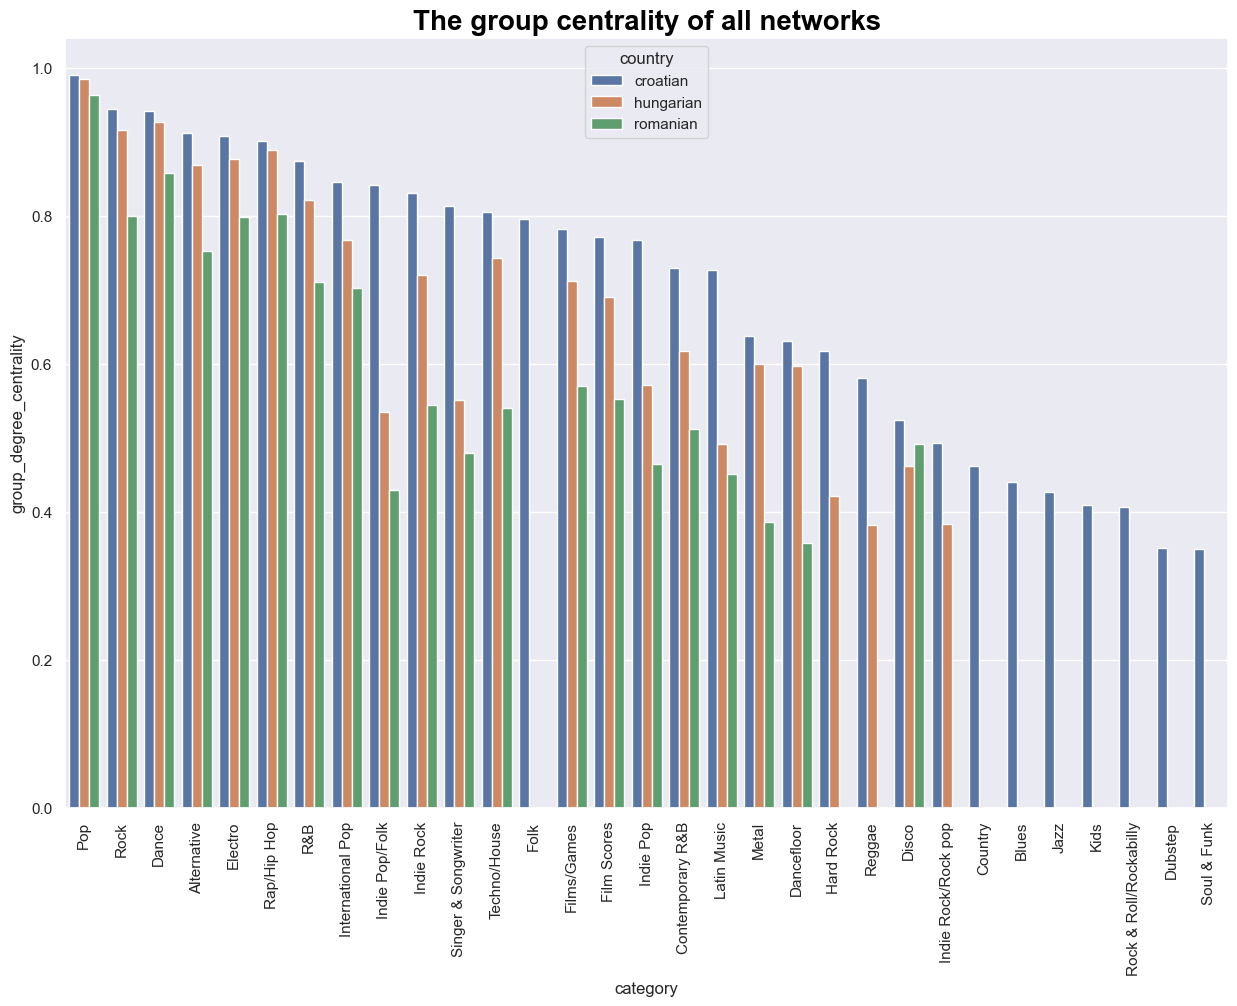

In [322]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
sns.barplot(data = cluster_df[cluster_df["group_degree_centrality"] > 0.35], x = "category", y = "group_degree_centrality",hue = "country").set_title("The group centrality of all networks", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})

## Unlike when we evaluate the nodes on an averaging basis, evaluating the categories on a group basis results in more consistent results across the board. Pop, rock, dance, alternative, electro, hip hop, and international pop have the highest group centrality in all of the countries. Pop has a value that is nearly 1, meaning that almost all nodes that don't contain pop as a category are still connected to a node with pop in their metadata somewhere in the network.

## We can also look at the groups with the lowest group centrality:

<Axes: xlabel='category', ylabel='group_degree_centrality'>

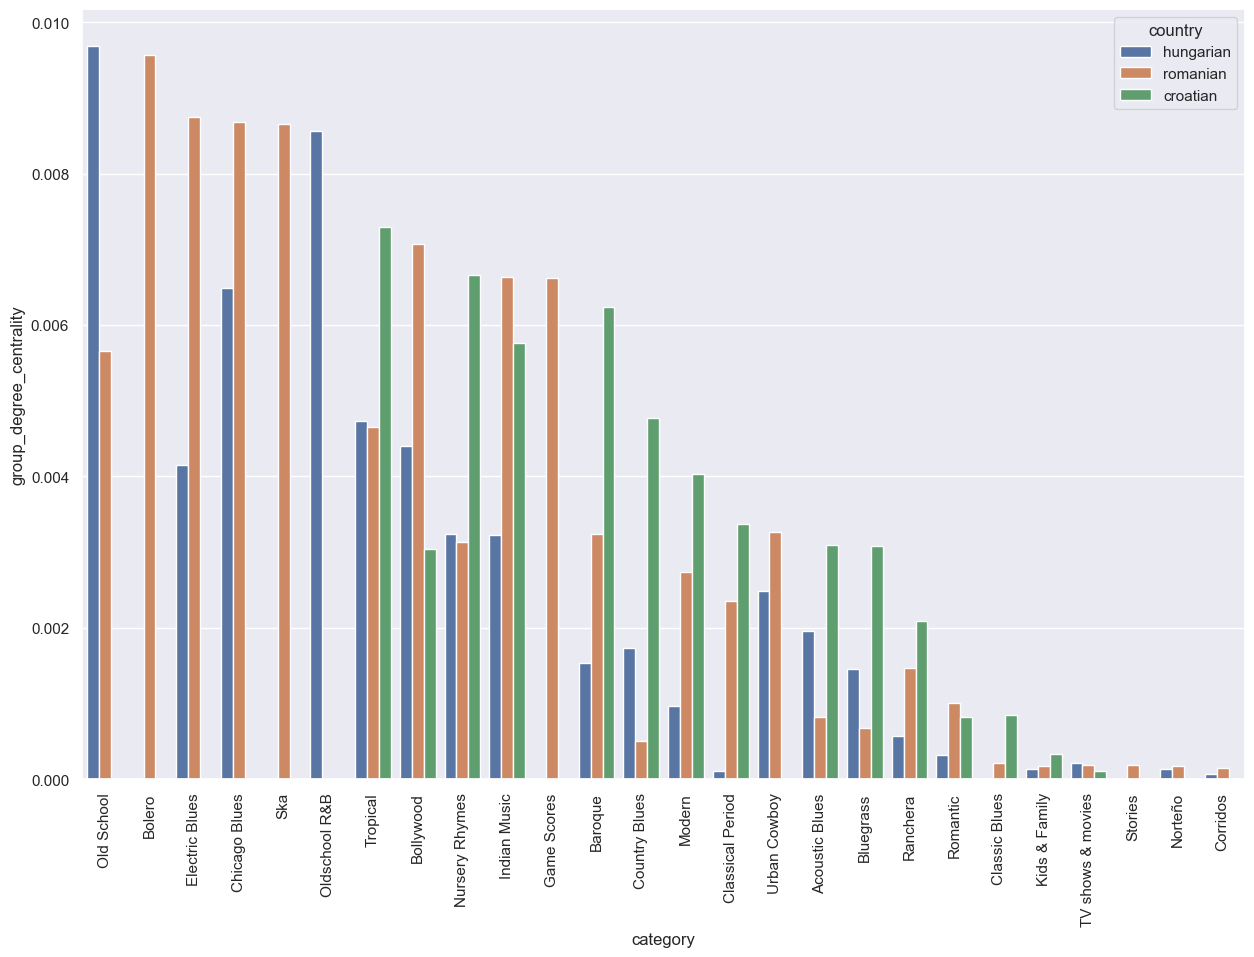

In [323]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
sns.barplot(data = cluster_df[cluster_df["group_degree_centrality"] < 0.01], x = "category", y = "group_degree_centrality",hue = "country")

Text(0.5, 1.0, 'Lowest Centrality Romanian Genres')

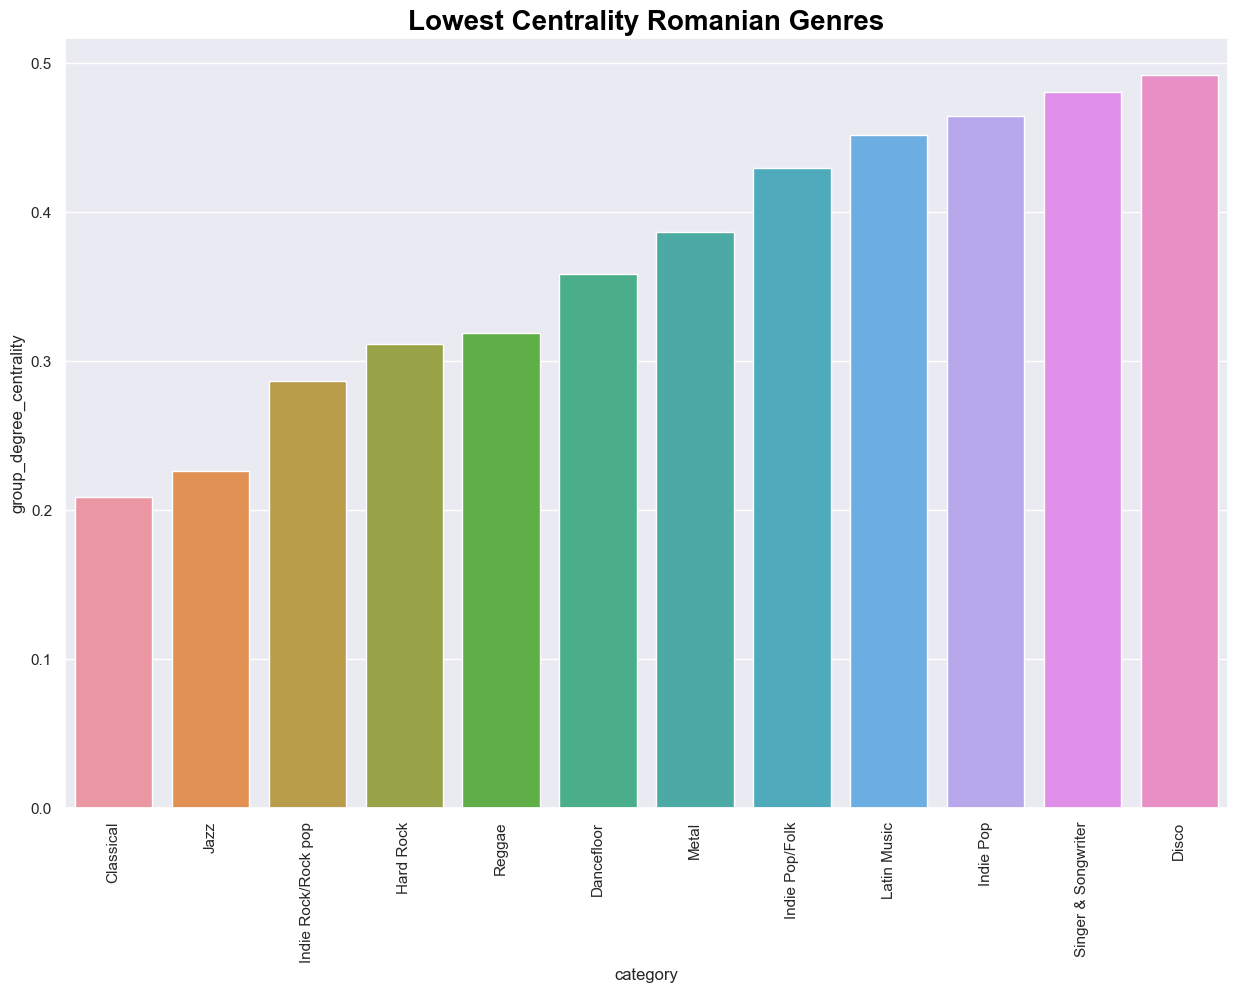

In [324]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
filter_df = country_genre_counts[country_genre_counts["romanian_counts"] >2000]["category"]

sns.barplot(data = cluster_df[(cluster_df["category"].isin(filter_df)) & (cluster_df["country"] == "romanian") & (cluster_df["group_degree_centrality"] < 0.5)].sort_values(by = "group_degree_centrality"), x = "category", y = "group_degree_centrality").set_title("Lowest Centrality Romanian Genres", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})



Text(0.5, 1.0, 'Lowest Centrality Croatian Categories')

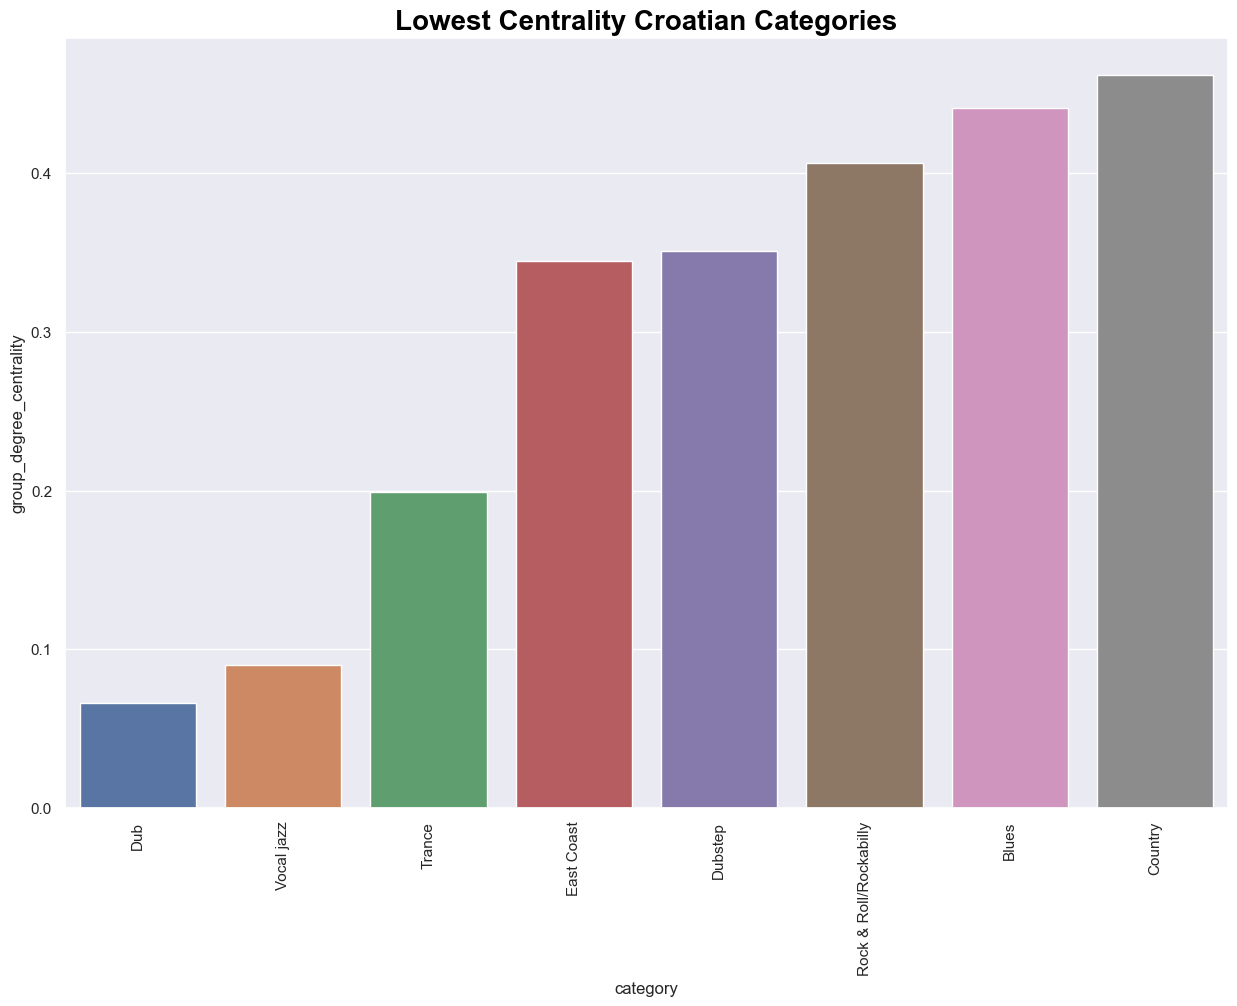

In [325]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
filter_df = country_genre_counts[country_genre_counts["croatian_counts"] > 2000]["category"]

sns.barplot(data = cluster_df[(cluster_df["category"].isin(filter_df)) & (cluster_df["country"] == "croatian") & (cluster_df["group_degree_centrality"] < 0.5)].sort_values(by = "group_degree_centrality"), x = "category", y = "group_degree_centrality").set_title("Lowest Centrality Croatian Categories", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})


Text(0.5, 1.0, 'Lowest Centrality Hungarian Genres')

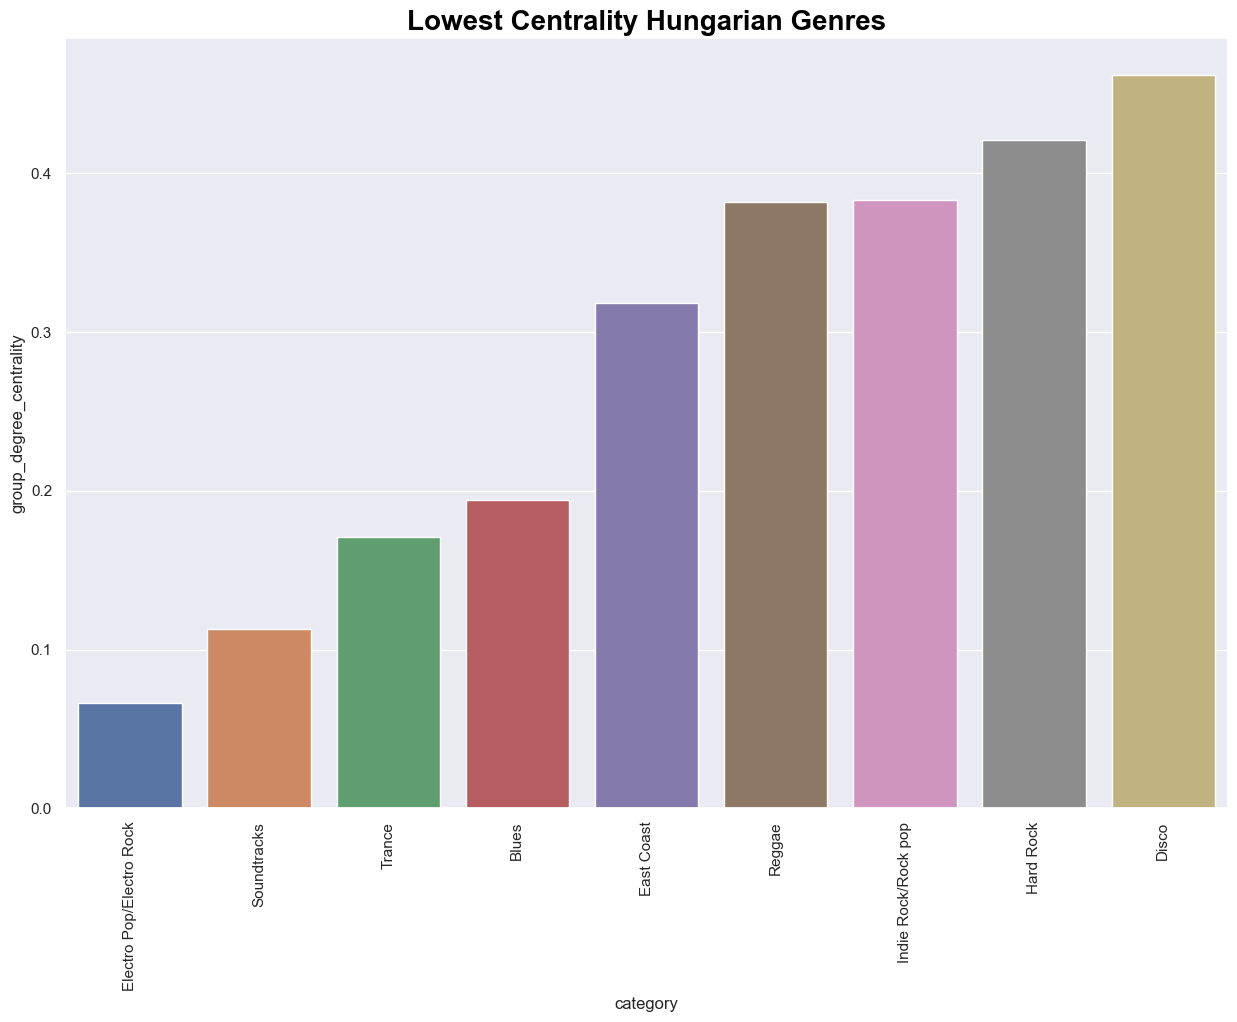

In [326]:
sns.set_theme(rc = {'figure.figsize':(15,10)})
plt.xticks(rotation = 90)
filter_df = country_genre_counts[country_genre_counts["hungarian_counts"] > 2000]["category"]

sns.barplot(data = cluster_df[(cluster_df["category"].isin(filter_df)) & (cluster_df["country"] == "hungarian") & (cluster_df["group_degree_centrality"] < 0.5)].sort_values(by = "group_degree_centrality"), x = "category", y = "group_degree_centrality").set_title("Lowest Centrality Hungarian Genres", fontdict = {"fontsize": 20,"fontweight":"bold","color":"black"})


## Certain musical categories are far less connected than others. We can see that more niche categories or those that are not in vogue are not all that connected. Categories such as blues, jazz and classical music all have low centrality, even though there are many nodes that have them as categories.

## Overall, we can conclude that:

## *The most popular categories (highest amount of nodes) don't necessarily score the highest in centrality measures
## *Niche music categories often contain less social (less connected) people
## *On a group centrality basis, pop music is by far the most central genre in all of the datasets
## *On an average node centrality basis, dance type music contains the highest centrality, but it is far less consistent across all the datasets